# Item Demand Forecasting
This notebook details some basic code to get a simple time series forecasting algorithms up and running for several item demand profiles. The focus here is not an optimised algorithm, but to create a simple base model from which we can explore the concepts of machine learning engineering in the rest of the book.

## The Problem
The problem outlined in the book is deceptively complex, so here we will re-iterate some of the details

1. The aim is to create a suite of forecasting models for many items in many regions
2. The user will interface with the models via a basic frontend
3. The user should have the ability to:
    a. Select the forecasts they want to see
    b. Ask for a retrain of the selected forecasting models (and then have the forecasts updated)
    c. [BONUS] Add conditional variables to perform scenario analysis
    
From a machine learning point of view this can be supplied via:

1. A batch training of N baseline models (N = combinations of region and product)
2. Storing of the models in MLFlow
3. The app, when requested for specific models, can retrieve the models from MLFlow and cache them for the session
4. The app, when requested for specific forecasts, can performt the forecasts on the cached models
5. The app, when requested for retrains, can send a request to trigger a training run of the selected models in the original batch system.
6. The training system, when requested for retrains, can compare performance against current models in MLFlow and decised to promote to 'production'
7. The app will have to detect that there is a new production model in MLFlow and replace current model (to work this out)

## This Notebook
This notebook will create some baseline experiments to show that forecasting can be done at the region and item level, but will not concern itself with scaling to all regions and items nor with the deployment architecture and methodology (to be discussed later in the book).

## Set Up

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import sys
!{sys.executable} -m pip install prophet
from prophet import Prophet


## Get Dataset

In [28]:
df = pd.read_csv('../data/rossman/train.csv')

C:\Users\timtu\AppData\Local\Temp\ipykernel_10840\1825714071.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/rossman/train.csv')


In [29]:
df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [30]:
df['Date'] = pd.to_datetime(df['Date'])

In [31]:
df[['Date', 'Store', 'Sales']]

,Date,Store,Sales
0,2015-07-31,1,5263
1,2015-07-31,2,6064
2,2015-07-31,3,8314
3,2015-07-31,4,13995
4,2015-07-31,5,4822
...,...,...,...
1017204,2013-01-01,1111,0
1017205,2013-01-01,1112,0
1017206,2013-01-01,1113,0
1017207,2013-01-01,1114,0


In [32]:
df[['StateHoliday','SchoolHoliday']].value_counts()

StateHoliday  SchoolHoliday
0             0                718965
              1                136122
              0                100984
              1                 30088
a             0                 15055
b             1                  6206
a             1                  5205
c             1                  4100
b             0                   484
dtype: int64

## Train basic forecaster

<AxesSubplot:xlabel='ds'>

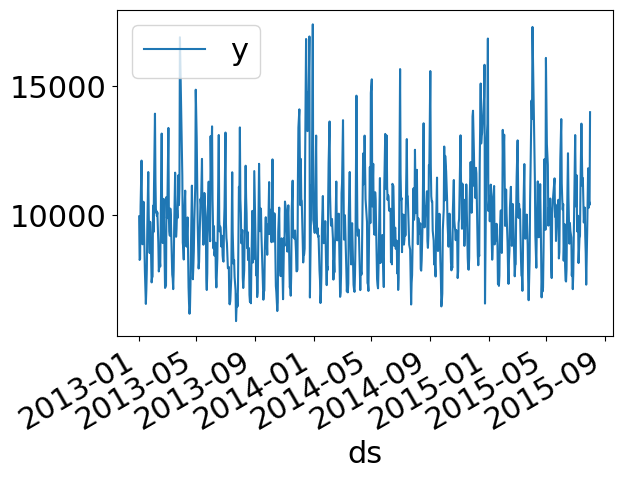

In [33]:
df.rename(columns= {'Date': 'ds', 'Sales': 'y'}, inplace=True)
df_store1 = df[
    (df['Store']==4) &\
    (df['Open']==1)
].reset_index(drop=True)
df_store1 = df_store1.sort_values('ds', ascending=True)
df_store1.plot(x='ds', y='y')

In [34]:
df_store1['DayOfWeek'].max()

6

In [35]:
# df_store1 = df_store1[['ds', 'y']].set_index('ds').resample('1W').mean().reset_index()
# df_store1.plot(x='ds', y='y')
# #df_store1[['ds', 'y']].set_index('ds').resample('1W').mean().reset_index().plot(x='ds', y='y')

In [36]:
# df_store1[
#     (df_store1['ds']>'2013-02') & (df_store1['ds']<'2013-09')
# ].sort_values('ds', ascending=False).plot(x='ds', y='y')

In [37]:
# df_store1 = df_store1[
#     (df_store1['ds']>'2013-02') & (df_store1['ds']<'2013-09')
# ]

In [38]:
df_store1.sort_values('ds', ascending=True)

,Store,DayOfWeek,ds,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
783,4,3,2013-01-02,9941,1429,1,0,0,1
782,4,4,2013-01-03,8247,1248,1,0,0,1
781,4,5,2013-01-04,8290,1232,1,0,0,1
780,4,6,2013-01-05,10338,1514,1,0,0,0
779,4,1,2013-01-07,12112,1562,1,1,0,0
...,...,...,...,...,...,...,...,...,...
4,4,1,2015-07-27,11812,1379,1,1,0,1
3,4,2,2015-07-28,10275,1191,1,1,0,1
2,4,3,2015-07-29,10514,1258,1,1,0,1
1,4,4,2015-07-30,10387,1276,1,1,0,1


In [39]:
seasonality = {
    'yearly': True,
    'weekly': True,
    'daily': False
}

def train_predict(df, train_index, seasonality=seasonality):
    # grab split data
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]
    
    #create Prophet model
    model=Prophet(
        yearly_seasonality=seasonality['yearly'],
        weekly_seasonality=seasonality['weekly'],
        daily_seasonality=seasonality['daily'],
        interval_width = 0.95
    )

    # train and predict
    model.fit(df_train)
    predicted = model.predict(df_test)
    return predicted, df_train, df_test
    
    
    
# def time_split_train_test(df, time_series_splits, seasonality=seasonality):
#     # for outputting
#     df_results = pd.DataFrame()
    
#     for i,(train_i,test_i) in enumerate(time_series_splits.split(df)):
        
#         # grab split data
#         df_train = df.copy().iloc[train_i,:]
#         df_test = df.copy().iloc[test_i,:]

#         # create Prophet model
#         model=Prophet(
#             yearly_seasonality=seasonality['yearly'],
#             weekly_seasonality=seasonality['weekly'],
#             daily_seasonality=seasonality['daily']
#         )

#         # train and predict
#         model.fit(df_train)
#         predicted = model.predict(df_test)

#         # combine pred and training df's for plotting
#         df_pred = predicted.loc[:,["ds","yhat"]]
        
#         df_pred["y"] = df_test['y'].tolist()
        
#         # Train or Test?
#         df_train["train"]=True
#         df_pred["train"]=False
        
#         df_sub = df_train.append(df_pred).reset_index(drop=True)
#         df_sub["split"]=i
#         df_sub["rmse"]=(np.mean((df_sub.yhat-df_sub.y)**2))**.5 #calculating rmse for the split
        
#         df_results = df_results.append(df_sub).reset_index(drop=True)
#     return df_results

In [40]:
train_index = int(0.8*df_store1.shape[0])
predicted, df_train, df_test = train_predict(
    df = df_store1,
    train_index = train_index,
    seasonality=seasonality
)

15:55:02 - cmdstanpy - INFO - Chain [1] start processing
15:55:02 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\timtu\Documents\GitHub\Machine-Learning-Engineering-with-Python\venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:677: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000019262193370> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


Text(0, 0.5, 'Sales')

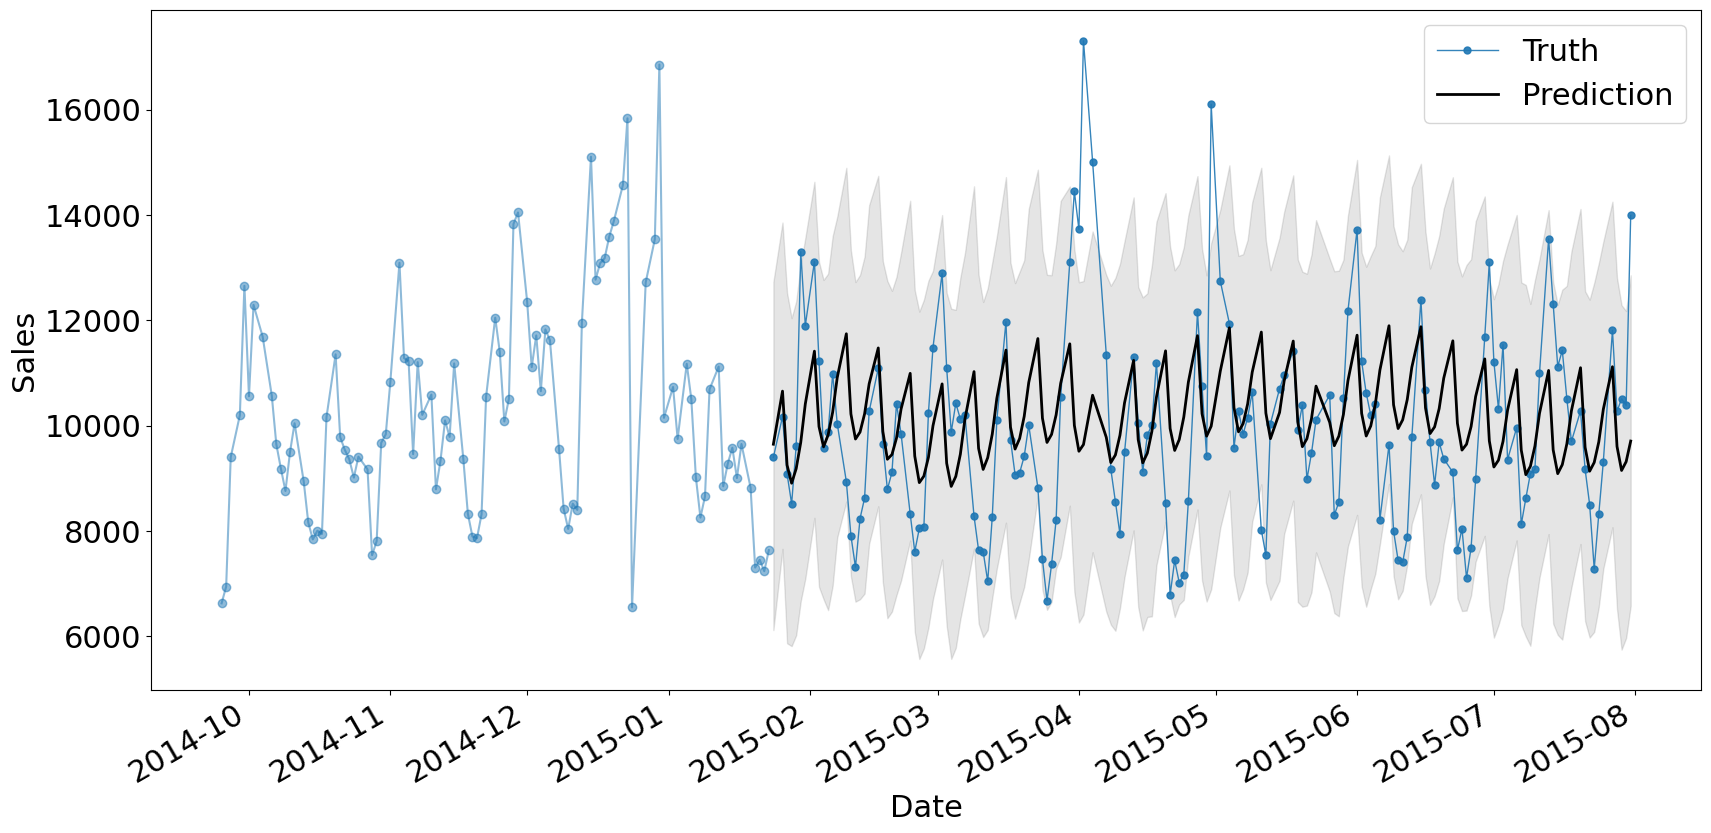

In [41]:
fig, ax = plt.subplots(figsize=(20,10))

df_test.plot(x='ds', y='y', ax=ax, label='Truth', linewidth=1, markersize=5, color='tab:blue',alpha=0.9, marker='o')
predicted.plot(x='ds', y='yhat', ax=ax, label='Prediction', linewidth=2, markersize=5, color='k')
ax.fill_between(x=predicted['ds'], y1=predicted['yhat_upper'], y2=predicted['yhat_lower'], alpha=0.1, color='k')
df_train.iloc[train_index-100:].plot(x='ds', y='y', ax=ax, color='tab:blue', label='_nolegend_', alpha=0.5, marker='o')

ax.set_xlabel('Date')
ax.set_ylabel('Sales')

In [42]:
train_index = int(0.8*df_store1.shape[0])
# grab split data
df_train = df_store1.copy().iloc[0:train_index]
df_test = df_store1.copy().iloc[train_index:]

#create Prophet model
model=Prophet(
    yearly_seasonality=seasonality['yearly'],
    weekly_seasonality=seasonality['weekly'],
    daily_seasonality=seasonality['daily']
)

# train and predict
model.fit(df_train)
predicted = model.predict(df_test)

10:11:14 - cmdstanpy - INFO - Chain [1] start processing
10:11:14 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
df_store1.iloc[0:train_index]

,Store,DayOfWeek,ds,y,Customers,Open,Promo,StateHoliday,SchoolHoliday
783,4,3,2013-01-02,9941,1429,1,0,0,1
782,4,4,2013-01-03,8247,1248,1,0,0,1
781,4,5,2013-01-04,8290,1232,1,0,0,1
780,4,6,2013-01-05,10338,1514,1,0,0,0
779,4,1,2013-01-07,12112,1562,1,1,0,0
...,...,...,...,...,...,...,...,...,...
161,4,1,2015-01-19,8825,1233,1,0,0,0
160,4,2,2015-01-20,7308,1120,1,0,0,0
159,4,3,2015-01-21,7456,1124,1,0,0,0
158,4,4,2015-01-22,7239,1073,1,0,0,0
